In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [27]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [28]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [29]:
# A better way to list all the unique labels

df["labels"].unique().tolist()[:10]

['chair',
 'car',
 'horse person',
 'bicycle',
 'person horse',
 'cat',
 'dog person',
 'bicycle person',
 'train',
 'aeroplane person']

### Sidebar: Pandas and DataFrames

In [10]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [11]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [14]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

In [ ]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

### End sidebar

### Constructing a DataBlock

In [30]:
dblock = DataBlock()

In [31]:
dsets = dblock.datasets(df)

In [32]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [33]:
x,y = dsets.train[0]
x,y

(fname       005624.jpg
 labels            bird
 is_valid         False
 Name: 2822, dtype: object,
 fname       005624.jpg
 labels            bird
 is_valid         False
 Name: 2822, dtype: object)

In [34]:
x['fname']

'005624.jpg'

In [35]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('006932.jpg', 'person')

In [36]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('009546.jpg', 'sofa person')

In [37]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/jupyter-master/.fastai/data/pascal_2007/train/006459.jpg'),
 ['horse', 'person', 'car'])

#### Note

**Here we use `MultiCategoryBlock` because we have multiple categories for the same image.**

We use `MultiCategoryBlock` when we need to be able to have multiple labels for each item. In other words, if your `get_y()` function returns multiple labels, then you need to use `MultiCategoryBlock`.

In [62]:
doc(MultiCategoryBlock)

In [38]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]))

Notice how `MultiCategoryBlock` now returns a `one-hot-encoding` of the labels.

In [41]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])

In [42]:
dsets.train[0][1]==1

TensorMultiCategory([False, False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False,  True, False,  True])

In [46]:
idxs = torch.where(dsets.train[0][1]==1.)[0]

In [47]:
idxs

TensorMultiCategory([ 8, 17, 19])

In [48]:
dsets.train.vocab[idxs]

(#3) ['chair','sofa','tvmonitor']

We have ignored the column is_valid up until now, which means that DataBlock has been using a random split by default.

In [56]:
df.index[~df['is_valid']].tolist()[:10]

[3, 5, 9, 11, 13, 14, 15, 16, 17, 20]

In [57]:
def splitter(df):
    """
    Creates a split between validation and non-validation sets.
    """
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

As we have discussed, **a DataLoader collates the items from a Dataset into a mini-batch**.

**A mini-batch is tuple of tensors, where each tensor simply stacks the items from that location in the Dataset item.**

The tupple consists of the `independent` and `dependent` variable.

#### Check the sizes of images in the dataset

In [63]:
from fastcore.parallel import *

def ret_image_size(f):
    return PILImage.create(f).size

In [68]:
train_images_path = (path/"train")

In [71]:
train_images_files = get_image_files(train_images_path)
train_images_files

(#5011) [Path('/home/jupyter-master/.fastai/data/pascal_2007/train/009337.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/009515.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/007421.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/000746.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/005998.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/009711.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/000104.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/006983.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/003436.jpg'),Path('/home/jupyter-master/.fastai/data/pascal_2007/train/004191.jpg')...]

In [74]:
%time parallel(ret_image_size, train_images_files)[:10]

CPU times: user 1.03 s, sys: 464 ms, total: 1.49 s
Wall time: 6.06 s


(#10) [(500, 349),(360, 270),(375, 500),(500, 333),(500, 346),(500, 374),(500, 333),(500, 333),(500, 375),(332, 500)]

Notice how the images have different sizes. We need to ensure that every item is of the same size. To do this, we can use `RandomResizedCrop`

In [58]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

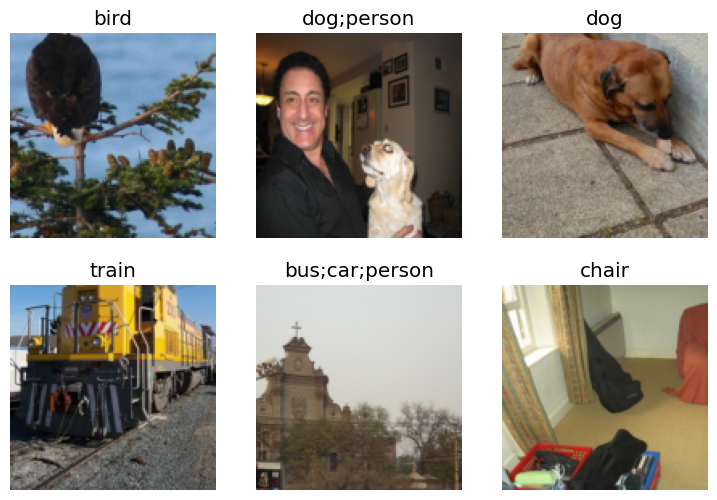

In [61]:
dls.show_batch(nrows=2, ncols=3)

In [75]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /home/jupyter-master/.fastai/data/pascal_2

### Binary Cross-Entropy

We are going to create our `Learner` which contains 4 things:
1. the `model`
2. `DataLoaders`
3. `Optimizer` - `SGD`
3. the `loss` function

In [76]:
learn = vision_learner(dls, resnet18)

Get the activations of the model by passing the first mini-batch.

In [79]:
doc(to_cpu)

In [88]:
x,y = to_cpu(dls.train.one_batch())

In [90]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 20]))

In [91]:
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [92]:
activs[0]

TensorImage([-1.5372, -2.2456, -1.2720,  0.7105, -0.5133,  1.5507,  0.8715, -1.9408, -0.6959,  3.2049,  1.9558,  0.5736, -2.0527,  2.7147,  1.1057,  0.4187,  3.9087, -0.1125,  2.0656, -1.4603],
            grad_fn=<AliasBackward0>)

Notice how the `activations` are not scaled to [0,1]. We need to apply `sigmoid` on them.

Here we define a loss function where we also apply the `log()` to because we have multiple categories.

Additional notes about `binary_cross_entropy` can be found in the previous chapter `05_pet_breeds`.

In [93]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be *less* than 1, if we don't think *any* of the categories appear in an image.


- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the other hand, the `binary_cross_entropy` function, which is just `mnist_loss` along with `log`, provides just what we need, thanks to the magic of PyTorch's elementwise operations. Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns.

Here, we use the same loss function but from the library of `pytorch`.

The `logit` part means that we have a `one-hot-encoding` of our labels.

In [97]:
nn.BCEWithLogitsLoss()
loss_func = nn.BCEWithLogitsLoss()

In [99]:
doc(TensorBase)

TensorBase([[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 1.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 1., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 1., 0., 0.]])

In [102]:
loss = loss_func(TensorBase(activs), TensorBase(y))
loss

TensorBase(1.0240, grad_fn=<AliasBackward0>)

**`Fastai` chooses the `loss` function for us, so it's not necessary to define it.**

In [104]:
dls.loss_func

FlattenedLoss of BCEWithLogitsLoss()

We also create an accuracy function which works for multi-label classification.

Note the `threshold` we set for picking the predicted labels on the images.

In [106]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

Python has a function called `partial()` which allows you to create versions of a defined function with different default values passed to its arguments.

In [107]:
doc(partial)

In [108]:
def say_hello(name, say_what="Hello"):
    return f"{say_what} {name}."

say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [109]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [110]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947655,0.711981,0.220578,00:05
1,0.816577,0.553582,0.281733,00:04
2,0.594820,0.197336,0.817191,00:04
3,0.354127,0.113157,0.949004,00:04


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126334,0.105687,0.947968,00:05
1,0.112307,0.096343,0.955398,00:05
2,0.097068,0.093644,0.958068,00:05


#### How do we find the optimal `threshold`?
It's important to pick a threshold which does not ommit correctly classified images.

The `threshold` is a `hyperparameter`.

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [117]:
doc(learn.get_preds)

In [118]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default get_preds applies the output activation function (sigmoid, in this case) for us, so we'll need to tell accuracy_multi to not apply it:

In [119]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9593)

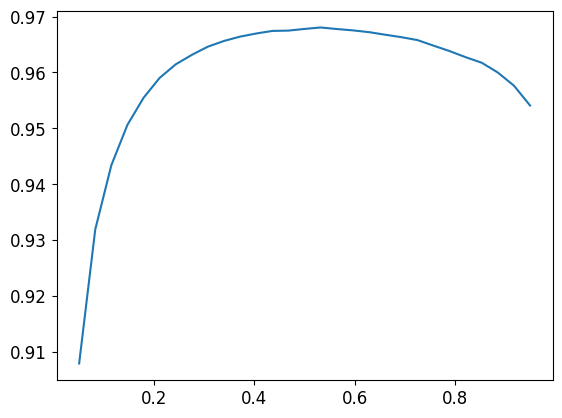

In [126]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

In [129]:
accuracy_multi(preds, targs, thresh=0.57), accuracy_multi(preds, targs, thresh=0.58), accuracy_multi(preds, targs, thresh=0.6)

(tensor(0.9635), tensor(0.9653), tensor(0.9671))

## Regression

To be able to move beyond fixed applications, to crafting your own novel solutions to novel problems, it helps to really understand the data block API (and maybe also the mid-tier API, which we'll see later in the book). As an example, let's consider the problem of image regression. This refers to learning from a dataset where the independent variable is an image, and the dependent variable is one or more floats. Often we see people treat image regression as a whole separate application—but as you'll see here, we can treat it as just another CNN on top of the data block API.

We're going to jump straight to a somewhat tricky variant of image regression, because we know you're ready for it! We're going to do a key point model. A key point refers to a specific location represented in an image—in this case, we'll use images of people and we'll be looking for the center of the person's face in each image. That means we'll actually be predicting two values for each image: the row and column of the face center.

### Assemble the Data

We will use the [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html)

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
#hide
Path.BASE_PATH = path

In [7]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [8]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside the subdirectories, we have different frames, each of them come with an image (_rgb.jpg) and a pose file (_pose.txt).

In [13]:
img_files = get_image_files(path)
def img2pose(x):
    """
    A function that converts an image filename to its associated pose file
    """
    return Path(f'{str(x)[:-7]}pose.txt')

In [141]:
img_files[:5]

(#5) [Path('01/frame_00319_rgb.jpg'),Path('01/frame_00409_rgb.jpg'),Path('01/frame_00128_rgb.jpg'),Path('01/frame_00471_rgb.jpg'),Path('01/frame_00236_rgb.jpg')]

In [142]:
img2pose(img_files[0])

Path('01/frame_00319_pose.txt')

In [143]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

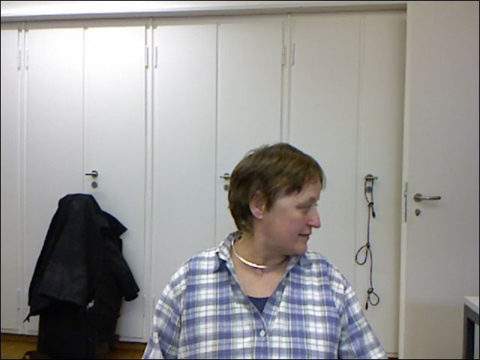

In [145]:
im.to_thumb(480)

The dataset description tells how you can locate the center of the face in the picture.

Bellow, is the function we use to extract the head center point.

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [147]:
get_ctr(img_files[0])

tensor([401.8926, 277.7943])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item.

We resize the images to half their size to speed the training up.

One important point to note is that we should not just use a random splitter. The reason for this is that the same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn't seen yet.

Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

In [154]:
img_files2 = get_image_files(path)
matching_image_files = []
for i in img_files2:
    if i.parent.name=='13':
        matching_image_files.append(i)
for i in range(10):
    print(matching_image_files[i])

/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00319_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00409_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00128_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00471_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00236_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00208_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00090_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00077_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00064_rgb.jpg
/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00168_rgb.jpg


In [173]:
# Create a function for viewing images in a data batch

def show_10_images(images, nof_items):
  """
  Displays a plot of 10 images and their labels from a data batch
  """
  # Setup teh figure
  plt.figure(figsize=(15,15))
  # Loop through the items
  for i in range(nof_items):
    # Creat subplots
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(PILImage.create(images[i]))
    # Turn off the grid display
    plt.axis("off")

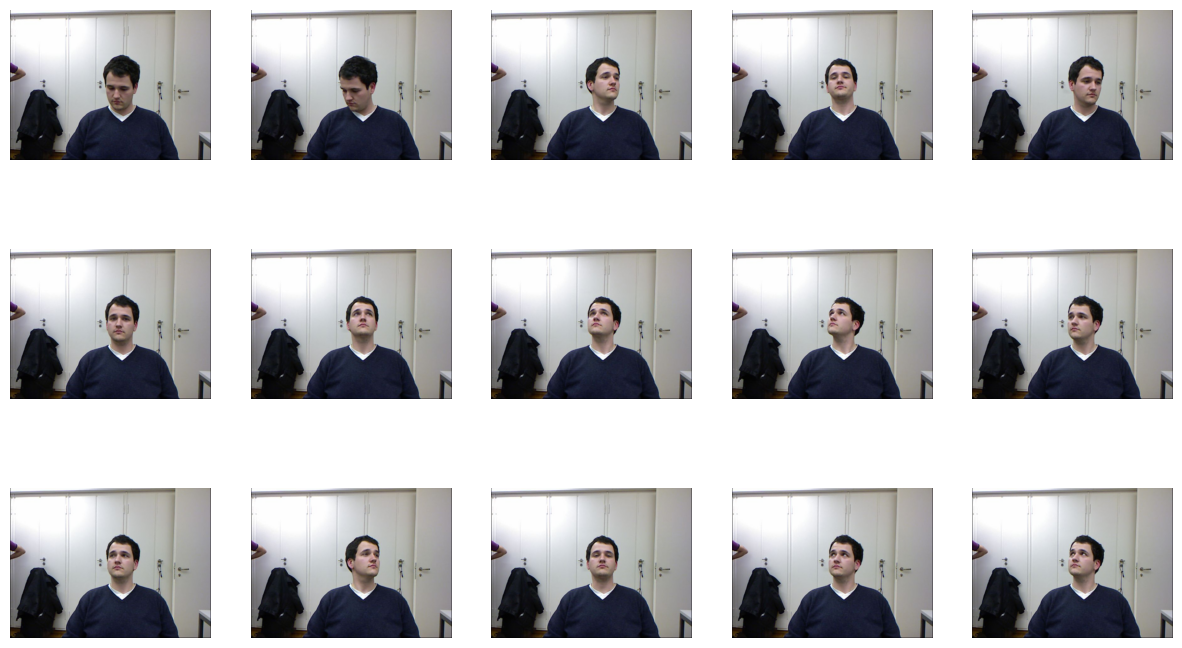

In [172]:
show_10_images(matching_image_files, 15)
#plt.imshow(PILImage.create("/home/jupyter-master/.fastai/data/biwi_head_pose/13/frame_00168_rgb.jpg"))

The only other difference from the previous data block examples is that the second block is a PointBlock. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [10]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

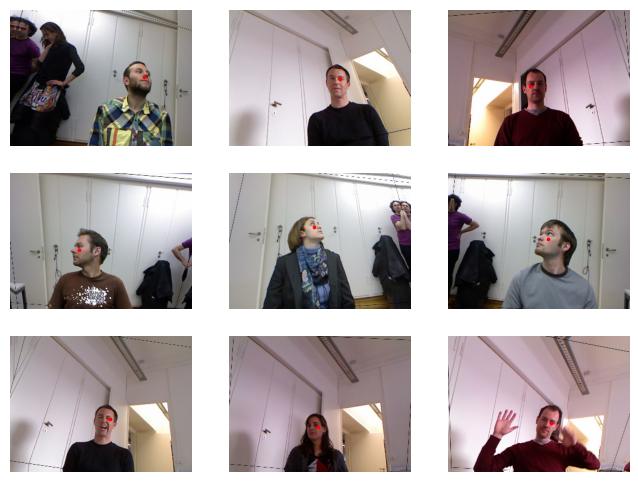

In [14]:
dls = biwi.dataloaders(path)
dls.train.show_batch(max_n=9, figsize=(8,6))

In [180]:
# Look into the shapes of the batches
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [181]:
yb[0]

TensorPoint([[-0.3441,  0.2286]], device='cuda:0')

### Training a Model

Create the learner and tell it to rescale the targets in [-1, 1]

In [15]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented in fastai using `sigmoid_range`, which is defined as following and forces the coordinates to be in the range `(lo,hi)`.

In [186]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x) * (hi-lo) + lo

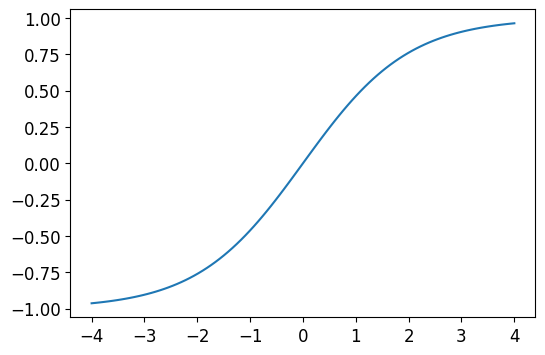

In [187]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [189]:
# Chooses the Pythagorian or L2 norm as a loss function
dls.loss_func

FlattenedLoss of MSELoss()

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root).

In [191]:
doc(learn.lr_find)

Minimum/10:	5.75e-03
Steepest point:	7.59e-07
Longest valley:	8.32e-04
Slide interval:	2.09e-01


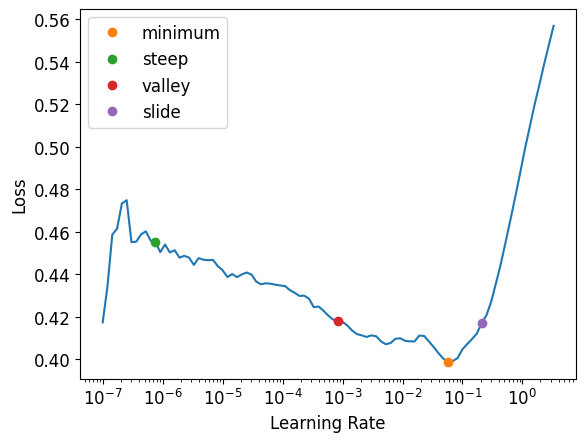

In [17]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

In [32]:
lr = 1e-2
learn.fine_tune(1, lr)

epoch,train_loss,valid_loss,time
0,0.001882,0.000907,00:27


epoch,train_loss,valid_loss,time
0,0.001300,0.000082,00:31


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [19]:
math.sqrt(0.0001)

0.01

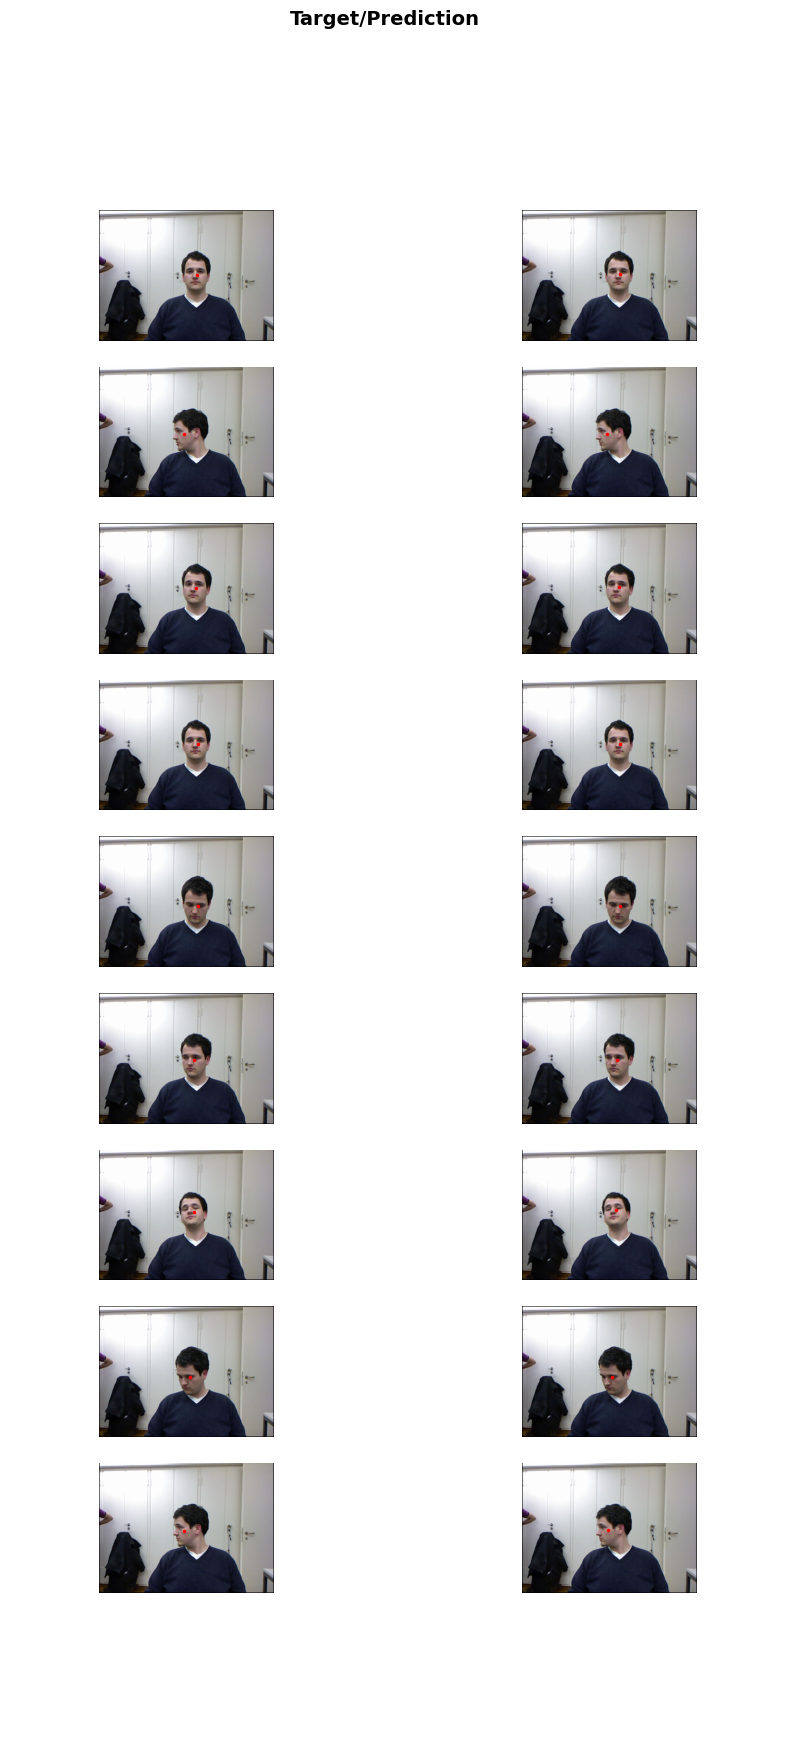

In [33]:
# Note how show_results shows the results on the validation dataset we selected above in the splitter.
learn.show_results(ds_idx=1, nrows=10, figsize=(10, 20))

epoch,train_loss,valid_loss,time
0,0.092124,0.002638,00:26


epoch,train_loss,valid_loss,time
0,0.008012,0.000839,00:32


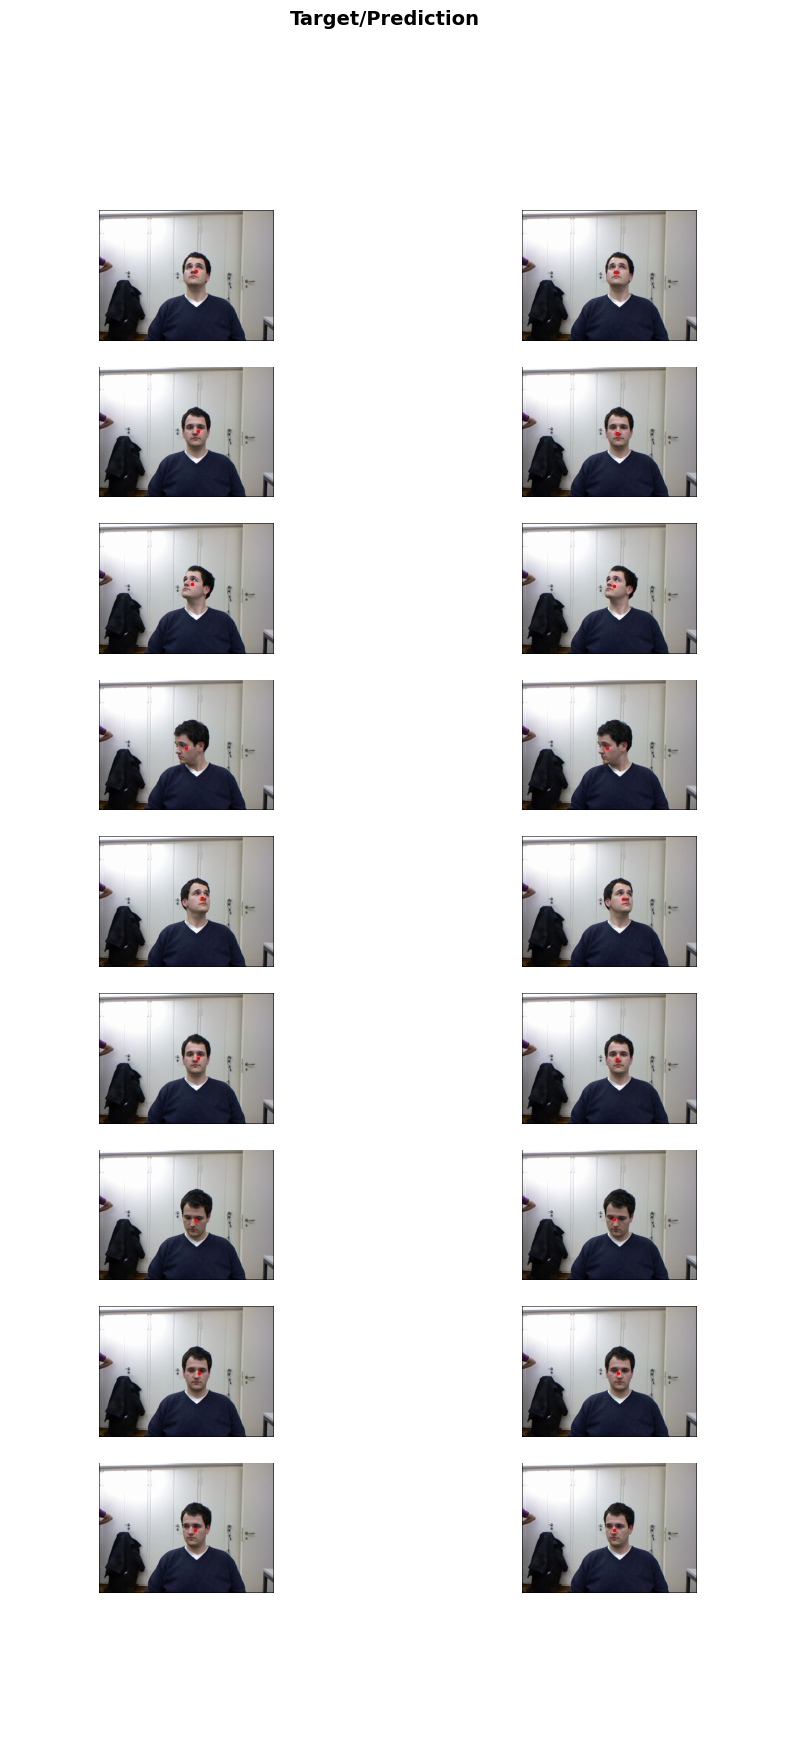

In [34]:
# Pick a different lr to force mistakes in the predictions
lr = 2.09e-01
learn.fine_tune(1, lr)
learn.show_results(ds_idx=1, nrows=10, figsize=(10, 20))

In [ ]:
# Pick a steep lr to force mistakes in the predictions
learn.fine_tune(1, lr_steep)
learn.show_results(ds_idx=1, nrows=10, figsize=(10, 20))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?


 It's a one-hot-encoding

3. How do you access the rows and columns of a DataFrame as if it was a matrix?

Using `.iloc()`.

4. How do you get a column by name from a DataFrame?

`df["column_name"]`

5. What is the difference between a `Dataset` and `DataLoader`?

The `DataLoader` consists of multiple `Dataset` items.

6. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?

`get_x` and `get_y`

2. Why is softmax not an appropriate output activation function when using a one hot encoded target?

It's useful only for single label predictions.

3. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?

Because we have multiple prediction probabilities and not just a single number.

2. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.